In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import Hull_White as hw
import mortgage as m
import Discount_Functions as disc_func
import itertools
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function
%matplotlib inline

In [2]:
cap_rate = 0.0475      # given in HW2_Data file
short_rate = 0.01816   # given in HW2_Data file
dt = 0.25

HW = hw.Hull_White()   #our Hull White class
K = 1/(1+cap_rate*dt)  #strike in put model

# from HW1 problem set
kappa = 0.153
sigma = 0.0153

# from HW1 REMIC data file
WACs = [0.05402, 0.05419]   # WAC values for two pools

In [3]:
df_stmat = pd.read_csv('stmat.csv')
df_tvmat = pd.read_csv('tvmat.csv')
df_disc_factors = pd.read_csv('discount factors.csv')
df_caplet_vols = pd.read_csv('caplet vols.csv')
df_mthly_10_yr_LIBOR_04 = pd.read_csv('monthly 10 year LIBOR spot rates for 2004.csv')

df_stmat['Coupon Gap'] = df_stmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal
df_tvmat['Coupon Gap'] = df_tvmat['Coupon Gap'] * 0.0001 # convert from basis points to decimal

#### Forward rates from dicsount functions

In [4]:
## import and clean data
data_z = pd.read_csv("discount factors.csv", header = 0)

## fit Z curve using OLS
data_z["poly"] = np.log(data_z["Price"])
z_OLS = disc_func.OLS(disc_func.power_5(data_z["Maturity"]), data_z["poly"])
print("my estimation of coefficients are:")
print(z_OLS.beta)

(a,b,c,d,e) = z_OLS.beta
coeff = [a,b,c,d,e]

my estimation of coefficients are:
[ -2.32447481e-02  -3.81606103e-03   1.62964402e-04  -3.02679751e-06
   2.09422571e-08]


In [5]:
# Comment by Kunming: Ignore this for now

#t_range = np.arange(1,241-3)/12
r0 = short_rate
#r0 = df_mthly_10_yr_LIBOR_04['Rate'][8]
'''libor_rate_arr = [df_mthly_10_yr_LIBOR_04['Rate'][i] for i in range(5,8)]
Z_arr = []
r_arr = []


for t in t_range:
    Z_10 = HW.Z(0, t+10, r0, kappa, sigma, coeff)
    Z_1 = HW.Z(0, t, r0, kappa, sigma, coeff)
    
    r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
    r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
    r_arr.append(HW.r_t(0, t+10, r0, kappa, sigma, coeff))
   
    # r(t1, t2) = (1/(t2 - t1)) * ( ln(DF(0,t1)) - ln(DF(0,t2)) )
    #libor_rate_arr.append((np.log(Z_1) - np.log(Z_10)) / (t+10 - t))
    libor_rate_arr.append((r_10*(t+10) - r_1*(t)) / (t+10 - t))
    
#plt.plot(libor_rate_arr[3:])
#plt.plot(r_arr)
plt.plot(libor_rate_arr)
print(libor_rate_arr[:8])
print(len(libor_rate_arr))
'''


"libor_rate_arr = [df_mthly_10_yr_LIBOR_04['Rate'][i] for i in range(5,8)]\nZ_arr = []\nr_arr = []\n\n\nfor t in t_range:\n    Z_10 = HW.Z(0, t+10, r0, kappa, sigma, coeff)\n    Z_1 = HW.Z(0, t, r0, kappa, sigma, coeff)\n    \n    r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)\n    r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)\n    r_arr.append(HW.r_t(0, t+10, r0, kappa, sigma, coeff))\n   \n    # r(t1, t2) = (1/(t2 - t1)) * ( ln(DF(0,t1)) - ln(DF(0,t2)) )\n    #libor_rate_arr.append((np.log(Z_1) - np.log(Z_10)) / (t+10 - t))\n    libor_rate_arr.append((r_10*(t+10) - r_1*(t)) / (t+10 - t))\n    \n#plt.plot(libor_rate_arr[3:])\n#plt.plot(r_arr)\nplt.plot(libor_rate_arr)\nprint(libor_rate_arr[:8])\nprint(len(libor_rate_arr))\n"

#### Ouput results from matlab functions

In [6]:
gamma = 0.0568
p = 2.9025
beta_1 = -12.6051
beta_2 = -2.0992

#### Standard error results from matlab code

In [7]:
gamma_se = 0.0018
p_se = 0.0750
beta_1_se = 1.9998
beta_2_se = 0.0495

# Q(a)

#### hazard function

In [8]:
beta = np.array([beta_1, beta_2])

def libor_rate_10yr_lag3(t):
    #here the time input t should be integer month
    if t==1:
        return 0.0539
    elif t==2:
        return 0.0522
    elif t==3:
        return 0.0510
    else:
        t = (t-3)/12
        r_10 = HW.r_t(0, t+10, r0, kappa, sigma, coeff)
        r_1 = HW.r_t(0, t, r0, kappa, sigma, coeff)
        return((r_10*(t+10) - r_1*(t)) / (t+10 - t))

def summer_index_func(t):
    # starting from Sept. plus 8
    t = t + 8
    return 1 if t%12 in [5,6,7,8] else 0

def hazard_func(t, gamma, p, beta, pool):
    #here the time input t should be integer month
    t = int(t)
    v = np.array([WACs[pool] - libor_rate_10yr_lag3(t), summer_index_func(t)])
    exp_val = np.dot(v, beta)
    return ((gamma*p * (gamma * t)**(p-1)) / (1 + (gamma * t)**p)) * np.exp(exp_val)

def SMM_func(tminus, tplus, gamma, p, beta, pool):
    int_res = sp.integrate.quad(lambda s: hazard_func(s, gamma, p, beta, pool), tminus, tplus)[0]
    return(1-np.exp(-int_res))


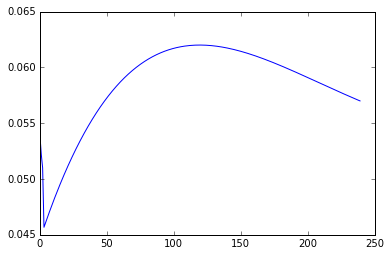

In [9]:
libor_rate_10yr_lag3_arr = []
t_range = np.arange(1,241)
for t in t_range:
    libor_rate_10yr_lag3_arr.append(libor_rate_10yr_lag3(t))
plt.plot(libor_rate_10yr_lag3_arr)

In [10]:
hazard_arr_1 = []
hazard_arr_2 = []
SMM_arr_1 = []
SMM_arr_2 = []

for t in range(1,241):
    hazard_arr_1.append(hazard_func(t, gamma, p, beta, 0))
    hazard_arr_2.append(hazard_func(t, gamma, p, beta, 1))
    SMM_arr_1.append(SMM_func(t-1, t, gamma, p, beta, 0))
    SMM_arr_2.append(SMM_func(t-1, t, gamma, p, beta, 1))
    
SMM_arr_1 = pd.Series(SMM_arr_1)
SMM_arr_2 = pd.Series(SMM_arr_2)

240
240


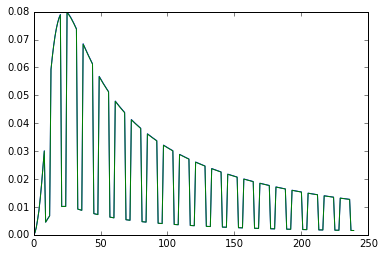

In [11]:
plt.plot(SMM_arr_1)
plt.plot(SMM_arr_2)
a = len(SMM_arr_1)
print(a)
print(len(SMM_arr_1))

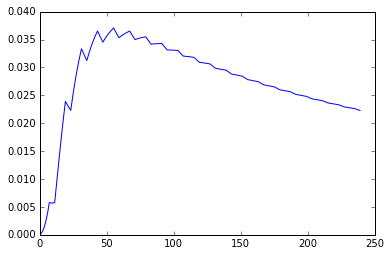

In [12]:
ave_hazard_arr_1 = np.cumsum(hazard_arr_1) / (t_range + 10)
ave_hazard_arr_2 = np.cumsum(hazard_arr_2) / (t_range + 10)
plt.plot(ave_hazard_arr_1)

# Qb

In [13]:
# basic information of two mortgage, for mortgage package
principal_1 = 77657656.75
monthly_interest_1 = 5.402/1200
payment_number_1 = 236
PSA_1 = 1.5
maturity_1 = 20
age_1 = 3

principal_2 = 128842343.35
monthly_interest_2 = 5.419/1200
payment_number_2 = 237
PSA_2 = 1.5
maturity_2 = 20
age_2 = 3

CG = 74800000
VE = 5200000
CM = 14000000
GZ = 22000000
TC = 20000000
CZ = 24000000
CA = 32550000
CY = 13950000
tranche_coupon = 5/(12*100)

In [14]:
pool_CF_1 = m.pool_CF(principal_1, monthly_interest_1, payment_number_1, PSA_1, maturity_1, age_1, SMM_arr_1)
pool_CF_2 = m.pool_CF(principal_2, monthly_interest_2, payment_number_2, PSA_2, maturity_2, age_2, SMM_arr_2)
summary_CF = m.summary_CF(pool_CF_1, pool_CF_2)
principal_CF_Alloc = m.Principal_CF_Alloc(summary_CF,tranche_coupon,CG,VE,CM,GZ,TC,CZ,CA,CY)
principal = m.Principal(principal_CF_Alloc)
balance = m.Balance(summary_CF,principal_CF_Alloc)
interest = m.Interest(balance,principal_CF_Alloc,summary_CF,tranche_coupon)
pricing = m.Pricing(principal,interest)


In [15]:
# Adjsut the order of column 
cols = pricing.columns.tolist()
cols = cols[6:7] + cols[1:2] + cols[8:9] + cols[2:3] + cols[5:6] + cols[7:8] + cols[4:5] + cols[0:1] + cols[3:4]
data_cashflow = pricing[cols]
data_cashflow.head()

,Period,CG,VE,CM,GZ,TC,CZ,CA,CY
1,1.0,7.913959e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,245983.816439,58125.0
2,2.0,9.031671e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,278467.323250,58125.0
3,3.0,1.197170e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,363911.987852,58125.0
4,4.0,1.644794e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,494002.518384,58125.0
5,5.0,2.143640e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,638979.629423,58125.0


In [16]:
# 5,000 simulation, so that the total number of paths is 10,000
num_sims = 1000
T = 20
dt = 1.0/12.0
dr = 10e-5  # dr taken to be arbitrarily small
## Simlation:
## cum_df_matrix = cumulative discount factor matrix
## cum_df_anti_matrix = cumulative discount factor matrix with antithetic path
(cum_df_matrix, cum_df_anti_matrix, r_matrix, r_anti_matrix) = HW.Monte_Carlo_2(kappa, sigma, r0, K, T, dt, coeff, num_sims)


# Price bonds
bonds = data_cashflow.iloc[:,1:]
bond_price_matrix = 0.5 * ((cum_df_matrix * np.matrix(bonds)) + (cum_df_anti_matrix * np.matrix(bonds)))
bond_prices = bond_price_matrix.mean(0).tolist()[0]
bond_prices = [float('%.3f' % x) for x in bond_prices]

# Get standard errors of bonds
standard_errors = HW.Std_Err(bond_price_matrix, num_sims)

# Residual

### V0

In [17]:
resid_tranche = summary_CF['Total_Interest'] + summary_CF['Total_Principal']

residual_cashflow = []
for r in r_matrix:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V0 = np.mean(residual_arr)
res_std = np.std(residual_arr) / math.sqrt(num_sims)

### V+ and V-

In [18]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

# V+
residual_cashflow = []
for r in r_matrix_p:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_p:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_plus = np.mean(residual_arr)

# V-
residual_cashflow = []
for r in r_matrix_m:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_m:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_minus = np.mean(residual_arr)

# Residual Duration

In [19]:
res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)

# Residual Convexity

In [20]:
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# Cash Flows for all 8 bonds

In [21]:
data_cashflow.head()

,Period,CG,VE,CM,GZ,TC,CZ,CA,CY
1,1.0,7.913959e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,245983.816439,58125.0
2,2.0,9.031671e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,278467.323250,58125.0
3,3.0,1.197170e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,363911.987852,58125.0
4,4.0,1.644794e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,494002.518384,58125.0
5,5.0,2.143640e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,638979.629423,58125.0


# Price of Bonds, Duration and Convexity

In [22]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

bond_price_matrix_p = 0.5 * ((cum_df_matrix_p * np.matrix(bonds)) + (cum_df_anti_matrix_p * np.matrix(bonds)))
bond_prices_p = bond_price_matrix_p.mean(0).tolist()[0]
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]

bond_price_matrix_m = 0.5 * ((cum_df_matrix_m * np.matrix(bonds)) + (cum_df_anti_matrix_m * np.matrix(bonds)))
bond_prices_m = bond_price_matrix_m.mean(0).tolist()[0]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]

par_price = np.array((CG,VE,CM,GZ,TC,CZ,CA,CY))

def oas_obj_func(oas,bond,i):
    dt = 1/12
    iterations = 240
    r_matrix_new = r_matrix + oas
    df_matrix_new = np.exp(-r_matrix_new*dt)
    cum_df_matrix_new = np.zeros((num_sims, iterations))
    for j in range(num_sims):
        cum_df_matrix_new[j,:] = df_matrix_new[j,:].cumprod()
    #return (cum_df_matrix_new * (np.matrix(bond).T)).mean()
    return (((cum_df_matrix_new * (np.matrix(bond).T)).mean() - par_price[i])/1e7)**2 

oas_arr = []
for i in range(8):
    oas_res = sp.optimize.minimize(lambda oas: oas_obj_func(oas, bonds.iloc[:,i],i),0.01)
    oas_arr.append(oas_res.x[0])

# merge results into dataframe
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, oas_arr],
columns=data_cashflow.columns[1:], 
index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])

### Add residual to final results

In [23]:
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]

### The bond price

In [24]:
df

,CG,VE,CM,GZ,TC,CZ,CA,CY,R
Bond Prices,7.700455e+07,5.379362e+06,1.459937e+07,2.317594e+07,2.115393e+07,2.562852e+07,3.371635e+07,1.480108e+07,308145.284307
Standard Errors,2.241570e+02,2.693700e+01,1.180980e+02,3.981780e+02,5.872720e+02,3.728435e+03,2.070600e+02,1.214866e+03,4008.844020
Effective Duration,9.950000e-01,1.185000e+00,1.488000e+00,1.925000e+00,2.165000e+00,3.410000e+00,1.241000e+00,2.720000e+00,-19.730591
Effective Convexity,1.113000e+00,1.580000e+00,2.281000e+00,3.711000e+00,4.893000e+00,1.218600e+01,1.762000e+00,8.330000e+00,-60.079659
OAS,2.589756e-02,2.478836e-02,2.385000e-02,2.183395e-02,2.006246e-02,1.199153e-02,2.433215e-02,1.476169e-02,NaN


# Q(c)

### Ouput results from matlab functions

In [25]:
gamma_non = 0.0048375
p_non = 1.31377
beta_1_non = 69.75265
beta_2_non = -0.4082

In [26]:
beta_non = np.array([beta_1_non, beta_2_non])
hazard_arr_1_non = []
hazard_arr_2_non = []
SMM_arr_1_non = []
SMM_arr_2_non = []

for t in range(1,241):
    hazard_arr_1_non.append(hazard_func(t, gamma_non, p_non, beta_non, 0))
    hazard_arr_2.append(hazard_func(t, gamma_non, p_non, beta_non, 1))
    SMM_arr_1_non.append(SMM_func(t-1, t, gamma_non, p_non, beta_non, 0))
    SMM_arr_2_non.append(SMM_func(t-1, t, gamma_non, p_non, beta_non, 1))
    
SMM_arr_1_non = pd.Series(SMM_arr_1_non)
SMM_arr_2_non = pd.Series(SMM_arr_2_non)

240
240


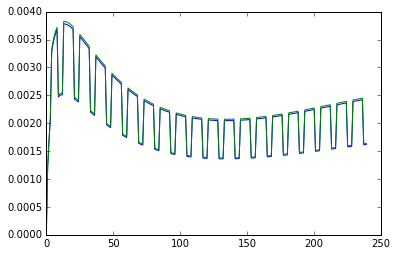

In [27]:
plt.plot(SMM_arr_1_non)
plt.plot(SMM_arr_2_non)
a_non = len(SMM_arr_1_non)
print(a_non)
print(len(SMM_arr_1_non))

In [28]:
pool_CF_1 = m.pool_CF(principal_1, monthly_interest_1, payment_number_1, PSA_1, maturity_1, age_1, SMM_arr_1_non)
pool_CF_2 = m.pool_CF(principal_2, monthly_interest_2, payment_number_2, PSA_2, maturity_2, age_2, SMM_arr_2_non)
summary_CF = m.summary_CF(pool_CF_1, pool_CF_2)
principal_CF_Alloc = m.Principal_CF_Alloc(summary_CF,tranche_coupon,CG,VE,CM,GZ,TC,CZ,CA,CY)
principal = m.Principal(principal_CF_Alloc)
balance = m.Balance(summary_CF,principal_CF_Alloc)
interest = m.Interest(balance,principal_CF_Alloc,summary_CF,tranche_coupon)
pricing = m.Pricing(principal,interest)


In [29]:
# Adjsut the order of column 
cols = pricing.columns.tolist()
cols = cols[6:7] + cols[1:2] + cols[8:9] + cols[2:3] + cols[5:6] + cols[7:8] + cols[4:5] + cols[0:1] + cols[3:4]
data_cashflow = pricing[cols]
data_cashflow.head()

,Period,CG,VE,CM,GZ,TC,CZ,CA,CY
1,1.0,7.913959e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,245983.816439,58125.0
2,2.0,9.842307e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,302026.426037,58125.0
3,3.0,1.058667e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,323659.531635,58125.0
4,4.0,1.118080e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,340926.265698,58125.0
5,5.0,1.305717e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,395458.304213,58125.0


In [30]:
# 5,000 simulation, so that the total number of paths is 10,000
num_sims = 1000
T = 20
dt = 1.0/12.0
dr = 10e-5  # dr taken to be arbitrarily small
## Simlation:
## cum_df_matrix = cumulative discount factor matrix
## cum_df_anti_matrix = cumulative discount factor matrix with antithetic path
(cum_df_matrix, cum_df_anti_matrix, r_matrix, r_anti_matrix) = HW.Monte_Carlo_2(kappa, sigma, r0, K, T, dt, coeff, num_sims)


# Price bonds
bonds = data_cashflow.iloc[:,1:]
bond_price_matrix = 0.5 * ((cum_df_matrix * np.matrix(bonds)) + (cum_df_anti_matrix * np.matrix(bonds)))
bond_prices = bond_price_matrix.mean(0).tolist()[0]
bond_prices = [float('%.3f' % x) for x in bond_prices]

# Get standard errors of bonds
standard_errors = HW.Std_Err(bond_price_matrix, num_sims)

### V+ and V-

In [31]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

# V+
residual_cashflow = []
for r in r_matrix_p:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_p:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_plus = np.mean(residual_arr)

# V-
residual_cashflow = []
for r in r_matrix_m:
    residual_cashflow.append(r * resid_tranche/24)
residual_cashflow = np.matrix(residual_cashflow)

residual_arr = []
for d in cum_df_matrix_m:
    residual_arr.append(np.dot(residual_cashflow,np.matrix(d).T))
res_V_minus = np.mean(residual_arr)

### Residual Duration and Convexity

In [32]:
res_dur = HW.Effective_Duration(res_V0, res_V_plus, res_V_minus, dr)
res_conv = HW.Effective_Convexity(res_V0, res_V_plus, res_V_minus, dr)

# Cash Flows for all 8 bonds
data_cashflow.head()

,Period,CG,VE,CM,GZ,TC,CZ,CA,CY
1,1.0,7.913959e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,245983.816439,58125.0
2,2.0,9.842307e+05,113333.333333,58333.333333,0.0,83333.333333,0.0,302026.426037,58125.0
3,3.0,1.058667e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,323659.531635,58125.0
4,4.0,1.118080e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,340926.265698,58125.0
5,5.0,1.305717e+06,113333.333333,58333.333333,0.0,83333.333333,0.0,395458.304213,58125.0


# Price of Bonds, Duration and Convexity



In [33]:
# Calculate V+ and V-
(cum_df_matrix_p, cum_df_anti_matrix_p, r_matrix_p, r_anti_matrix_p) = HW.Monte_Carlo_2(kappa, sigma, r0+dr, K, T, dt, coeff, num_sims)
(cum_df_matrix_m, cum_df_anti_matrix_m, r_matrix_m, r_anti_matrix_m) = HW.Monte_Carlo_2(kappa, sigma, r0-dr, K, T, dt, coeff, num_sims)

bond_price_matrix_p = 0.5 * ((cum_df_matrix_p * np.matrix(bonds)) + (cum_df_anti_matrix_p * np.matrix(bonds)))
bond_prices_p = bond_price_matrix_p.mean(0).tolist()[0]
bond_prices_p = [float('%.3f' % x) for x in bond_prices_p]

bond_price_matrix_m = 0.5 * ((cum_df_matrix_m * np.matrix(bonds)) + (cum_df_anti_matrix_m * np.matrix(bonds)))
bond_prices_m = bond_price_matrix_m.mean(0).tolist()[0]
bond_prices_m = [float('%.3f' % x) for x in bond_prices_m]

# Calculate effective duration
eff_durs = HW.Effective_Duration(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_durs = [float('%.3f' % x) for x in eff_durs]

# Calculate effective convexity
eff_conv = HW.Effective_Convexity(bond_prices, bond_prices_p, bond_prices_m, dr)
eff_conv = [float('%.3f' % x) for x in eff_conv]

par_price = np.array((CG,VE,CM,GZ,TC,CZ,CA,CY))

def oas_obj_func(oas,bond,i):
    dt = 1/12
    iterations = 240
    r_matrix_new = r_matrix + oas
    df_matrix_new = np.exp(-r_matrix_new*dt)
    cum_df_matrix_new = np.zeros((num_sims, iterations))
    for j in range(num_sims):
        cum_df_matrix_new[j,:] = df_matrix_new[j,:].cumprod()
    #return (cum_df_matrix_new * (np.matrix(bond).T)).mean()
    return (((cum_df_matrix_new * (np.matrix(bond).T)).mean() - par_price[i])/1e7)**2 

oas_arr = []
for i in range(8):
    oas_res = sp.optimize.minimize(lambda oas: oas_obj_func(oas, bonds.iloc[:,i],i),0.01)
    oas_arr.append(oas_res.x[0])

# merge results into dataframe
df = pd.DataFrame([bond_prices, standard_errors, eff_durs, eff_conv, oas_arr],
columns=data_cashflow.columns[1:], 
index=['Bond Prices', 'Standard Errors', 'Effective Duration', 'Effective Convexity','OAS'])

# Add residual to final result
df['R'] = [res_V0, res_std, res_dur, res_conv, np.nan]


In [34]:
df

,CG,VE,CM,GZ,TC,CZ,CA,CY,R
Bond Prices,7.879372e+07,5.435898e+06,1.490424e+07,2.298818e+07,2.058220e+07,2.306526e+07,3.416260e+07,1.401416e+07,308145.284307
Standard Errors,5.111184e+03,1.198720e+02,3.297514e+03,1.297170e+04,1.257730e+04,3.596191e+04,7.288922e+03,1.220355e+04,4008.844020
Effective Duration,2.310000e+00,1.712000e+00,3.720000e+00,5.002000e+00,4.490000e+00,5.917000e+00,3.115000e+00,4.655000e+00,-19.730591
Effective Convexity,6.817000e+00,3.698000e+00,1.507000e+01,2.506500e+01,2.250500e+01,3.503100e+01,1.232000e+01,2.450400e+01,-60.079659
OAS,1.578645e-02,2.034123e-02,9.812337e-03,3.803438e-03,2.300002e-03,-3.093075e-03,8.659682e-03,-2.757834e-04,NaN
